In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score

plt.style.use('ggplot')
plt.rcParams['figure.figsize']= [15, 4]

df = pd.read_excel('data/generated_daily_features.xlsx', index_col=0).loc[1961:2017]
display(df.head())

,Pl: debourrement - floraison,Pl: fleur,Pl: floraison - veraison,Pl: veraison - vendanges,Pl: vendanges,Tm: debourrement - floraison,Tm: fleur,Tm: floraison - veraison,Tm: veraison - vendanges,Tm: vendanges,...,Stress: fleur,Stress: floraison - veraison,Stress: veraison - vendanges,Stress: vendanges,Growing Season Tm,Winter Rain,GDD10,Stress,Evap,Log price
1961,1.448529,2.380000,1.323529,0.325000,3.307143,12.645588,14.573333,18.823529,19.543182,18.392857,...,-11.5,35.20,59.2,-62.35,17.506011,5.003289,2249.1,-100.788369,2.544385,7.335145
1962,1.526786,0.880000,0.609836,1.072340,2.013636,13.421429,18.350000,19.372131,18.642553,14.913636,...,9.3,85.85,20.9,-27.20,16.615847,3.417763,2111.4,-84.065766,2.035612,6.325255
1963,1.738806,0.137500,2.782456,2.910417,1.146429,13.837313,17.250000,19.056140,16.883333,14.575000,...,10.6,-60.40,-85.7,-10.15,16.104372,2.480921,1961.5,-295.452193,4.241228,5.887723
1964,2.471930,3.885714,0.532787,1.505000,7.166667,14.382456,18.335714,19.865574,19.725000,15.126667,...,-28.6,98.95,1.1,-192.15,17.648087,1.697386,2232.2,-89.012582,3.281639,5.831882
1965,1.513158,1.216667,1.455319,5.017021,0.963158,13.022368,18.800000,18.968085,16.259574,16.163158,...,11.1,17.20,-184.3,-3.45,15.809836,2.731579,1852.7,-301.282979,3.738298,5.781001


In [2]:
def r_squared(x, y):
    return 1 - np.sum(np.square(x - y))/np.sum(np.square(x - np.mean(x)))

print(r_squared(np.array([1, 2, 3]), np.array([2,2,2])))

0.0


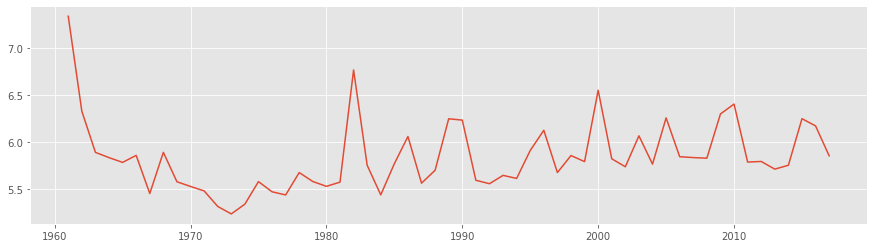

In [3]:
from sklearn.preprocessing import StandardScaler

X = df.drop('Log price', axis=1)

X['GDD10'] = X['GDD10']/1000
X['Square GDD10'] = X['GDD10']**2

#X['Square Winter Tx'] = X['Winter Tx']**2

#X['Tm Growing Season'] = np.mean(X[['Tm: floraison - veraison', 'Tm: veraison - vendanges']].values, axis=1)
X['Growing Season Tm'] = np.abs(X['Growing Season Tm']-18)

X['Square Growing Season Tm'] = X['Growing Season Tm']**2

X['Square Tn: debourrement - floraison'] = X['Tn: debourrement - floraison']**2

#X['Tm Growing Season'] = np.mean(X[['Tm: debourrement - floraison', 'Tm: floraison - veraison', 'Tm: veraison - vendanges']].values, axis=1)/16
#X['Square Tm Growing Season'] = X['Tm Growing Season']**2

#cols = [col for col in list(X.columns) if 'Tm Growing' not in col]
#X[cols] = pd.DataFrame(StandardScaler().fit_transform(X[cols]), index=X.index, columns=X[cols].columns).loc[1961:,:]

#X['Stress: veraison - fin vendanges'] = X['Evap: veraison - fin vendanges']
X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns).loc[1961:,:]

COLUMN_NAMES = X.columns.to_list()
y = df[['Log price']]
plt.plot(y)

In [4]:
GOOD_FEATURES = ['P: veraison - vendanges', 'Stress', 'DTR: veraison - vendanges', 'P: fleur', 'Sun: veraison - vendanges']

init_dict = {
    'Growing Season Tm':-0.1,
    'Square Growing Season Tm':-0.1,
    'DTR: veraison - vendanges':0.2,
    'P: veraison - vendanges':-0.2,
    'Stress':0.2,
    'P: fleur':-0.1,
    'Wind: fleur':0.1,
    'Tm: floraison - veraison':0.1,
    'Floraison-veraison interval':-0.1,
    'Tx: debourrement - floraison':0.1,
    'DTR: debourrement - floraison':-0.1,
    'Dormancy':0.1,

}

class Regressive_Model(torch.nn.Module):
    """Optimizes over the whole given dataframe"""
    def __init__(self, init_dict, length):
        super().__init__()
        
        self.weights = {}
        self.length = length
        self.type = {}
        self.weights_intercept = torch.nn.Parameter(torch.from_numpy(-0.3*np.ones(self.length)))
        
        self.walk_params = torch.nn.ParameterList([])
        for feature in GOOD_FEATURES:
            if feature in init_dict.keys():
                self.walk_params.append(torch.nn.Parameter(torch.from_numpy(init_dict[feature]*np.ones(self.length))))
            else:
                self.walk_params.append(torch.nn.Parameter(torch.from_numpy(0.1*np.random.randn(self.length))))

        self.where_to_find_walks = [COLUMN_NAMES.index(coeff_name) for coeff_name in GOOD_FEATURES]
        
        self.scalar_params = torch.nn.ParameterList([])
        self.where_to_find_scalars = [COLUMN_NAMES.index(coeff_name) for coeff_name in []]
        
    def forward(self, X):
        """ 
        Forward pass of the model on one vintage
        """
        result = torch.ones(self.length)*6
        result += self.weights_intercept
        for i in range(len(self.walk_params)):
            result += self.walk_params[i] * X[:,self.where_to_find_walks[i]]
            
        for i in range(len(self.scalar_params)):
            result += self.scalar_params[i] * X[:,self.where_to_find_scalars[i]]
        return result
    
    def loss_regularize_intercept(self):
        return torch.mean((self.weights_intercept[1:] - self.weights_intercept[:-1])*(self.weights_intercept[1:] - self.weights_intercept[:-1]))\
    /torch.max(torch.abs(self.weights_intercept))
    
    def loss_regularize_walk_coeffs(self):
        loss = 0
        for t in self.walk_params:
            loss += torch.mean((t[1:] - t[:-1])*(t[1:] - t[:-1])) / torch.max(torch.abs(t))
        return loss
    
    def loss_target(self, X, y):
        return torch.mean((y - self.forward(X))*(y - self.forward(X)))
    
    def combined_loss(self, X, y):
        return self.loss_target(X, y) + 10* self.loss_regularize_walk_coeffs()\
                + 10*self.loss_regularize_intercept()
                #+ self.loss_keep_close_to_prior()
        
def training_loop(model, optimizer, scheduler, n=1000):
    "Training loop for torch model."
    losses = []
    for i in tqdm(range(n)):
        loss = model.combined_loss(X_tensor, y_tensor)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        losses.append(loss)  
    return losses

In [ ]:
X_tensor = torch.FloatTensor(X.values)
y_tensor = torch.from_numpy(y['Log price'].values)

model = Regressive_Model(init_dict, len(y))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

losses = training_loop(model, optimizer, scheduler, 4000)

plt.plot(losses)
plt.show()

In [ ]:
fig, axs = plt.subplots(3,3)
subplot = axs[0, 0]
coeff = 'intercept'
subplot.plot(range(1961, 2018), model.weights_intercept.detach().numpy(), color='green')
subplot.set_title('intercept')
for i in range(len(model.scalar_params)):
    n = i+1
    subplot = axs[n//3, n%3]
    subplot.plot(range(1961, 2018), [model.scalar_params[i]]*44, color='green').axhline(0., color='black')

    subplot.set_title(COLUMN_NAMES[model.where_to_find_scalars[i]])
    

for i in range(len(model.walk_params)):
    n = len(model.scalar_params) + i+1
    subplot = axs[n//3, n%3]

    subplot.plot(range(1961, 2018), model.walk_params[i].detach().numpy(), color='green')
    subplot.axhline(0., color='black')
    subplot.set_title(COLUMN_NAMES[model.where_to_find_walks[i]])
plt.show()

optimal_temp =  (- model.walk_params[0].detach().numpy() / (2*model.walk_params[1].detach().numpy()))*18 # x = -b/2a
plt.plot(optimal_temp)

### Avec Tm et Square Tm

Spearman correlation between results and real log prices: 
 0.6678260869565217
 
Spearman correlation between results and real log prices / full: 
 0.7168784029038113
 
### Sans Tm et square Tm
 
 Spearman correlation between results and real log prices: 
 0.7208695652173912
 
Spearman correlation between results and real log prices / full: 
 0.7192118226600986

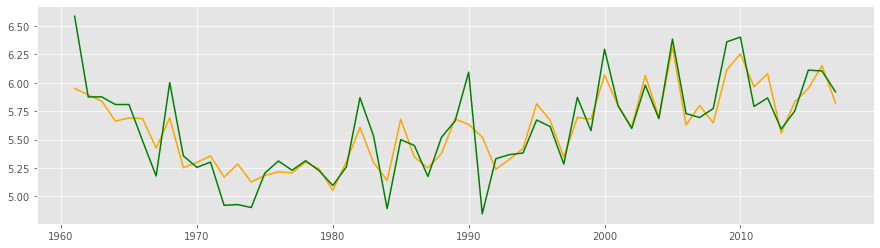

Spearman correlation between results and real log prices: 
 0.8721739130434782
Spearman correlation between results and real log prices / full: 
 0.8861772812951014


In [94]:
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

full_predictions  = model(X_tensor).detach().numpy()
predictions = full_predictions[33:]

plt.plot(range(1961, 2018), full_predictions, color='orange')
plt.plot(y['Log price'], color='g')
plt.show()
print('Spearman correlation between results and real log prices: \n', spearmanr(predictions, y.loc[1994:2018, 'Log price']).correlation)
print('Spearman correlation between results and real log prices / full: \n', spearmanr(full_predictions, y.loc[1961:2018, 'Log price']).correlation)

# Ante 1994 model

Highlight the clear perf difference: continuing the line instead of just averaging the last coefficients gives a strong edge

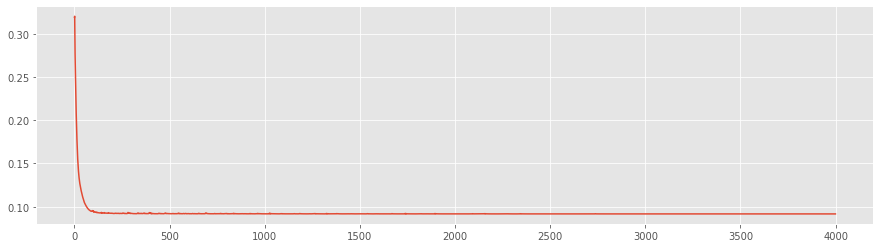

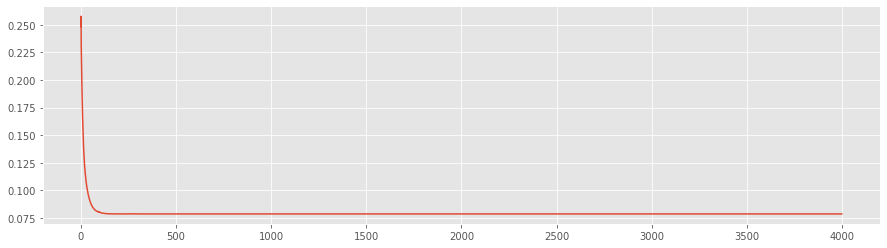

In [166]:
FIRST = 1961
LAST = 1993

X_tensor = torch.FloatTensor(X.loc[FIRST : LAST, :].values)
y_tensor = torch.from_numpy(y.loc[FIRST : LAST, 'Log price'].values)
GOOD_FEATURES = ['Stress', 'DTR: veraison - vendanges', 'P: fleur']

training_length = LAST - FIRST + 1
vintage_model_1994 = Regressive_Model(init_dict, training_length)
optimizer = torch.optim.Adam(vintage_model_1994.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
losses = training_loop(vintage_model_1994, optimizer, scheduler, 4000)
plt.plot(losses)
plt.show()


GOOD_FEATURES = ['Stress', 'DTR: veraison - vendanges', 'P: fleur']

FIRST = 1961
LAST_2 = 2004
X_tensor = torch.FloatTensor(X.loc[FIRST : LAST_2, :].values)
y_tensor = torch.from_numpy(y.loc[FIRST : LAST_2, 'Log price'].values)
    
vintage_model_2005 = Regressive_Model(init_dict, LAST_2-FIRST+1)
optimizer = torch.optim.Adam(vintage_model_2005.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)
losses = training_loop(vintage_model_2005, optimizer, scheduler, 4000)
plt.plot(losses)
plt.show()

In [84]:
from sklearn.linear_model import LinearRegression

def extrapolate_coeffs(model_coeffs_list, model_year_range, target_vintage):
    predicted_coeffs = []
    for coeffs in model_coeffs_list:
        line = LinearRegression()
        #line.fit(model_year_range, coeffs)
        line.fit(model_year_range[-15:], coeffs[-15:])
        
        predicted_coeffs.append(line.predict(np.array(target_vintage).reshape(1,-1)))
        #predicted_coeffs.append(np.mean(coeffs[-5:]))
    return predicted_coeffs

 
def predict_vintage(X, model, model_year_range, target_vintage):
    result = 6
    walk_params = [walk.detach().numpy() for walk in model.walk_params]
    model_extrapolated_walk_coeffs = extrapolate_coeffs(walk_params, model_year_range, target_vintage)
    model_extrapolated_intercept = extrapolate_coeffs([model.weights_intercept.detach().numpy()], model_year_range, target_vintage)[0]
    
    result += model_extrapolated_intercept

    for i in range(len(model_extrapolated_walk_coeffs)):
        result += model_extrapolated_walk_coeffs[i] * X[model.where_to_find_walks[i]]
    return result

In [168]:
predictions=[]
for vintage in tqdm(range(1994, 2018)):
    predictions.append(predict_vintage(
        X.loc[vintage, :],
        vintage_model_1994,
        np.array(range(FIRST, LAST + 1)).reshape(-1,1),
        vintage
                      ))
    
predictions_2=[]
for vintage in tqdm(range(2005, 2018)):
    predictions_2.append(predict_vintage(
        X.loc[vintage, :],
        vintage_model_2005,
        np.array(range(FIRST, LAST + 1)).reshape(-1,1),
        vintage
                      ))

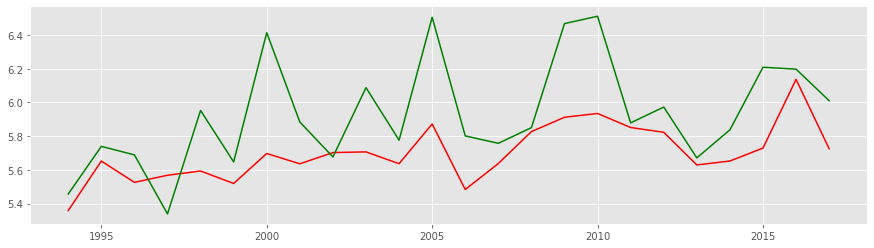

Spearman correlation between results and real log prices: first period
 0.6363636363636364
Spearman correlation between results and real log prices: second period
 0.8076923076923077
Spearman correlation between results and real log prices: second period model 2
 0.8791208791208791
Spearman correlation between results and real log prices: complete
 0.7704347826086956
MAE  between results and real log prices: complete
 0.32776112374891714 

Spearman correlation between results and real log prices: combined
 0.7878260869565217
MAE  between results and real log prices: combined
 0.4990419801364707 

R2 between results and real log prices: complete
 -0.07288950727010657


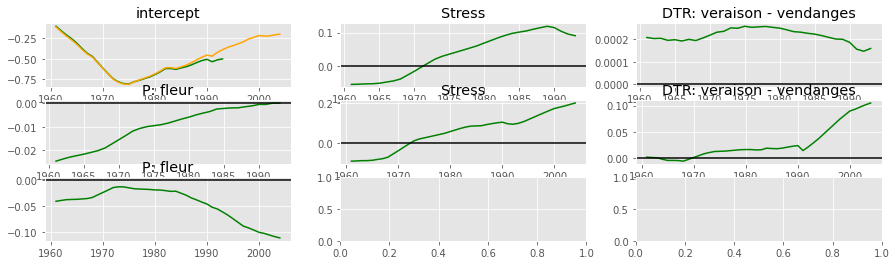

In [169]:

plt.plot(range(1994, 2018), predictions, color='red')
#plt.plot(range(2005, 2018), predictions_2, color='orange')

plt.plot(y.loc[1994:2017, 'Log price'], color='g')
plt.show()
print('Spearman correlation between results and real log prices: first period\n', spearmanr(predictions[:11], y.loc[1994:2004, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: second period\n', spearmanr(predictions[11:], y.loc[2005:2017, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: second period model 2\n', spearmanr(predictions_2, y.loc[2005:2017, 'Log price'].values).correlation)

print('Spearman correlation between results and real log prices: complete\n', spearmanr(predictions, y.loc[1994:2017, 'Log price'].values).correlation)
print('MAE  between results and real log prices: complete\n', np.mean(np.abs(predictions- y.loc[1994:, 'Log price'].values)), '\n')

print('Spearman correlation between results and real log prices: combined\n', spearmanr(predictions[:11]+predictions_2, y.loc[1994:2017, 'Log price'].values).correlation)
print('MAE  between results and real log prices: combined\n', np.mean(np.abs(predictions[:11]+predictions_2- y.loc[1994:2017, 'Log price'].values)), '\n')

print('R2 between results and real log prices: complete\n', r2_score(y.loc[1994:2017, 'Log price'].values, predictions))

fig, axs = plt.subplots(3,3)
subplot = axs[0, 0]
coeff = 'intercept'
subplot.plot(range(FIRST, LAST+1), vintage_model_1994.weights_intercept.detach().numpy(), color='green')
subplot.plot(range(FIRST, LAST_2+1), vintage_model_2005.weights_intercept.detach().numpy(), color='orange')
subplot.set_title('intercept')

for i in range(len(vintage_model_1994.walk_params)):
    n =  i+1
    subplot = axs[n//3, n%3]

    subplot.plot(range(FIRST, LAST + 1), vintage_model_1994.walk_params[i].detach().numpy(), color='green')
    subplot.axhline(0., color='black')
    subplot.set_title(COLUMN_NAMES[vintage_model_1994.where_to_find_walks[i]])
    
for i in range(len(vintage_model_2005.walk_params)):
    n = len(vintage_model_1994.walk_params) + i+1
    subplot = axs[n//3, n%3]

    subplot.plot(range(FIRST, LAST_2 + 1), vintage_model_2005.walk_params[i].detach().numpy(), color='green')
    subplot.axhline(0., color='black')
    subplot.set_title(COLUMN_NAMES[vintage_model_2005.where_to_find_walks[i]])

Avec Tm et Square, en utilisant les coeffs 93:
- Spearman: 0.55


Sans Tm et Square : 
- 0.575381140598532

Le meme, avec interpolation lineaire sur tous les coeffs du modele
- 0.62

Le meme, avec interpolation lineaire sur les 10 derniers coeffs du modele
- 0.62




Spearman correlation between results and real log prices: first period
 - 0.63

Spearman correlation between results and real log prices: second period
 - 0.76

Spearman correlation between results and real log prices: complete
 - 0.69
 
# Model 1984 - 1994
 
Spearman correlation between results and real log prices: first period
 0.6545454545454547
Spearman correlation between results and real log prices: second period
 0.8727272727272729
Spearman correlation between results and real log prices: complete
 0.7368718238283457
 
 
 
# Meme periode sans GDD10 et SquareGDD10

 Spearman correlation between results and real log prices: first period
 0.6090909090909091
Spearman correlation between results and real log prices: second period
 0.8545454545454546
Spearman correlation between results and real log prices: complete
 0.7312252964426879
 
 
 # Avec meilleure loss function
 Spearman correlation between results and real log prices: first period
 0.6090909090909091
Spearman correlation between results and real log prices: second period
 0.881818181818182
Spearman correlation between results and real log prices: complete
 0.7425183512140034
 
 
# Params ['Floraison-veraison interval', 'Stress', 'P: veraison - vendanges']
 
 Spearman correlation between results and real log prices: first period
 0.6454545454545455
Spearman correlation between results and real log prices: second period
 0.8545454545454546
Spearman correlation between results and real log prices: complete
 0.7425183512140034
 
 
# Params ['Floraison-veraison interval', 'Stress', 'P: veraison - vendanges', 'DTR: veraison - vendanges']

Spearman correlation between results and real log prices: first period
 0.6545454545454547
Spearman correlation between results and real log prices: second period
 0.8090909090909091
Spearman correlation between results and real log prices: complete
 0.7594579333709771
 
 
  
# Params ['Floraison-veraison interval', 'Stress', 'DTR: veraison - vendanges', 'Tx: debourrement - floraison']
0.81

# Params ['Floraison-veraison interval', 'Stress', 'P: veraison - vendanges', 'DTR: veraison - vendanges']

Spearman correlation between results and real log prices: first period
 0.8454545454545455
Spearman correlation between results and real log prices: second period
 0.8272727272727273
Spearman correlation between results and real log prices: complete
 0.813664596273292
 
 
 
 Deuxieme essai: 0.65
 
 
 # Params ['Stress', 'DTR: veraison - vendanges']
 Spearman 0.72
 
 
 # Params ['DTR: veraison - vendanges', 'Stress', 'P: veraison - vendanges']

Spearman correlation between results and real log prices: complete
 0.706
 
 
# Stress, DTR, Floraison - veraison interval
Spearman correlation between results and real log prices: complete
0.699

# Stress tout seul
0.707

# Stress, DTR: veraison - vendanges
0.73

# Stress, P: veraison - vendanges
0.71

# Stress, DTR
0.72




# Medoc, avec 'P: veraison - vendanges', 'DTR: veraison - vendanges', 'Wind: fleur', 'P: fleur', 'Sun: veraison - vendanges'
0.68 (contre 0.698)

# Bayesian model

In [177]:
GOOD_FEATURES = ['Stress', 'DTR: veraison - vendanges', 'P: fleur']


class Bayesian_Model(torch.nn.Module):
    """Optimizes over the whole given dataframe in a Bayesian way"""
    def __init__(self, init_dict, length):
        super().__init__()
        
        self.weights = {}
        self.length = length
        self.type = {}
        self.intercept_mean = torch.nn.Parameter(torch.from_numpy(-0.2*np.ones(self.length)))
        self.intercept_logvar = torch.nn.Parameter(torch.from_numpy(-4*np.ones(self.length)))

        self.walk_means = torch.nn.ParameterList([])
        for feature in GOOD_FEATURES:
            if feature in init_dict.keys():
                self.walk_means.append(torch.nn.Parameter(torch.from_numpy(init_dict[feature]*np.ones(self.length))))
            else:
                self.walk_means.append(torch.nn.Parameter(torch.from_numpy(0.2*np.random.rand(self.length))))
        
        self.where_to_find_walks = [COLUMN_NAMES.index(coeff_name) for coeff_name in GOOD_FEATURES]
        
        self.walk_logvars = torch.nn.ParameterList([])
        for feature in GOOD_FEATURES:
            self.walk_logvars.append(torch.nn.Parameter(torch.from_numpy(-4*np.ones(self.length))))

        self.scalar_params = torch.nn.ParameterList([])
        
    def sample_walks(self):
        walk_sample = []
        for i in range(len(self.walk_means)):
            walk_sample.append(self.walk_means[i] + torch.randn_like(self.walk_means[i]) * torch.exp(0.5 * self.walk_logvars[i])) # Element-wise multiplication of epsilon with variance
        return walk_sample

        
    def forward(self, X):
        """ 
        Forward pass of the model on one vintage
        """
        result = torch.ones(self.length)*6 
        result += self.intercept_mean + torch.randn_like(self.intercept_mean) * torch.exp(0.5 * self.intercept_logvar)
        
        walk_samples = self.sample_walks()
        for i in range(len(walk_samples)):
            result += walk_samples[i] * X[:,self.where_to_find_walks[i]]
            
            
        return result
    
    def loss_regularize_intercept(self):
        return torch.mean((self.intercept_mean[1:] - self.intercept_mean[:-1])*(self.intercept_mean[1:] - self.intercept_mean[:-1]))\
    /torch.max(torch.abs(self.intercept_mean))
    
    def loss_regularize_walk_coeffs(self):
        loss = 0
        for t in self.walk_means:
            loss += torch.mean((t[1:] - t[:-1])*(t[1:] - t[:-1])) / torch.max(torch.abs(t))
        return loss
    
    def loss_target(self, X, y):
        return torch.mean((y - self(X))*(y - self(X)))
    
    def combined_loss(self, X, y):
        return self.loss_target(X, y) + 10* self.loss_regularize_walk_coeffs()\
                + 10*self.loss_regularize_intercept()
                #+ self.loss_keep_close_to_prior()
        
    def predict_extra_vintage(self, X):
        """ 
        Predicts the vintage just after the trained range, based on data in X
        """
        result = 6
        coefficients = {}
        coefficients['intercept'] = self.intercept_mean[-1]
        result += coefficients['intercept']
        
        for i in range(len(self.walk_means)):
            coeff_name = COLUMN_NAMES[self.where_to_find_walks[i]]
            coefficients[coeff_name] = self.walk_means[i][-1]
            result += coefficients[coeff_name] * X[self.where_to_find_walks[i]]
            
        return result, coefficients

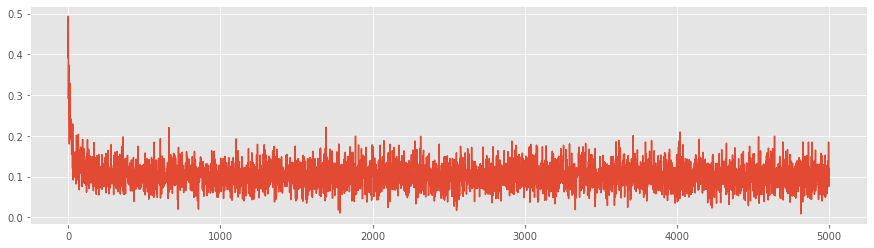

In [178]:
def training_loop_bayes(model, optimizer,scheduler, n=1000):
    "Training loop for torch model."
    losses = []
    for i in tqdm(range(n)):
        loss = model.combined_loss(X_tensor, y_tensor + 0.10*np.random.randn(len(y_tensor)))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        losses.append(loss)  
    return losses

FIRST = 1961
LAST = 1993

X_tensor = torch.FloatTensor(X.loc[FIRST : LAST, :].values)
y_tensor = torch.from_numpy(y.loc[FIRST : LAST, 'Log price'].values)
    
training_length = LAST - FIRST + 1
vintage_model_1994 = Bayesian_Model(init_dict, training_length)

optimizer = torch.optim.Adam(vintage_model_1994.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

losses = training_loop_bayes(vintage_model_1994, optimizer, scheduler, 5000)
        
plt.plot(losses)
plt.show()

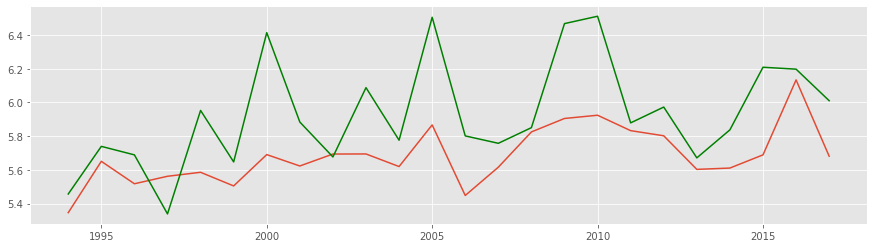

Spearman correlation between results and real log prices: first period
 0.6454545454545455
Spearman correlation between results and real log prices: second period
 0.7967032967032966
Spearman correlation between results and real log prices: complete
 0.7556521739130433


In [179]:
def predict_vintage_bayesian(X, model, model_year_range, target_vintage):
    result = 6
    walk_params = [walk.detach().numpy() for walk in model.walk_means]
    model_extrapolated_walk_coeffs = extrapolate_coeffs(walk_params, model_year_range, target_vintage)
    model_extrapolated_intercept = extrapolate_coeffs([model.intercept_mean.detach().numpy()], model_year_range, target_vintage)[0]
    
    result += model_extrapolated_intercept

    for i in range(len(model_extrapolated_walk_coeffs)):
        result += model_extrapolated_walk_coeffs[i] * X[model.where_to_find_walks[i]]
    return result

predictions=[]
for vintage in tqdm(range(1994, 2018)):
    predictions.append(predict_vintage_bayesian(
        X.loc[vintage, :],
        vintage_model_1994,
        np.array(range(FIRST, LAST + 1)).reshape(-1,1),
        vintage
                      ))
    
from scipy.stats import spearmanr
plt.plot(range(1994, 2018), predictions)
plt.plot(y.loc[1994:2017, 'Log price'], color='g')
plt.show()
print('Spearman correlation between results and real log prices: first period\n', spearmanr(predictions[:11], y.loc[1994:2004, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: second period\n', spearmanr(predictions[11:], y.loc[2005:2017, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: complete\n', spearmanr(predictions, y.loc[1994:2017, 'Log price'].values).correlation)

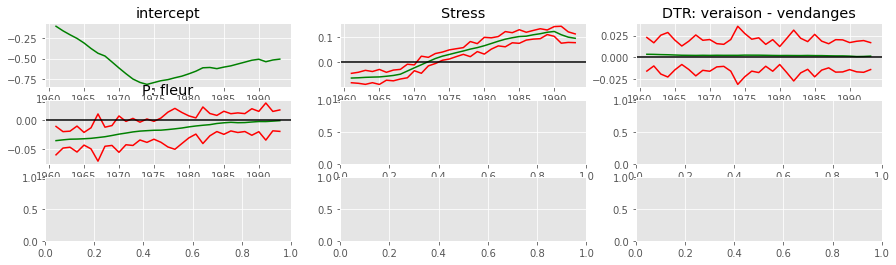

In [180]:
fig, axs = plt.subplots(3,3)
subplot = axs[0, 0]
coeff = 'intercept'
subplot.plot(range(FIRST, 1994), vintage_model_1994.intercept_mean.detach().numpy(), color='green')
subplot.set_title('intercept')

for i in range(len(vintage_model_1994.walk_means)):
    n = i+1
    subplot = axs[n//3, n%3]

    subplot.plot(range(FIRST, LAST + 1), vintage_model_1994.walk_means[i].detach().numpy() - np.exp(vintage_model_1994.walk_logvars[i].detach().numpy()), color='red')
    subplot.plot(range(FIRST, LAST + 1), vintage_model_1994.walk_means[i].detach().numpy(), color='green')
    subplot.plot(range(FIRST, LAST + 1), vintage_model_1994.walk_means[i].detach().numpy() + np.exp(vintage_model_1994.walk_logvars[i].detach().numpy()), color='red')

    subplot.axhline(0., color='black')
    subplot.set_title(COLUMN_NAMES[vintage_model_1994.where_to_find_walks[i]])

# All mobile coeffs model

In [85]:
GOOD_FEATURES = ['Stress', 'DTR: veraison - vendanges', 'P: fleur', 'Wind: fleur']
coefficients_df = pd.DataFrame(index = range(1994, 2018), columns = ['intercept'] + GOOD_FEATURES)
next_coefficients_df = pd.DataFrame(index = range(1994, 2019), columns = ['intercept'] + GOOD_FEATURES)
next_next_coefficients_df = pd.DataFrame(index = range(1994, 2020), columns = ['intercept'] + GOOD_FEATURES)


for vintage in range(1994, 2018):
    print(vintage)
    FIRST = 1961
    LAST = vintage - 1
    
    X_tensor = torch.FloatTensor(X.loc[FIRST : LAST, :].values)
    y_tensor = torch.from_numpy(y.loc[FIRST : LAST, 'Log price'].values)
    
    training_length = LAST - FIRST + 1
        
    vintage_model = Regressive_Model(init_dict, training_length)
    
    optimizer = torch.optim.Adam(vintage_model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    losses = training_loop(vintage_model, optimizer, scheduler, 4000)
    
    # Fill coefficients dataframe
    model_year_range = np.array(range(FIRST, LAST + 1)).reshape(-1,1)
    
    walk_params = [walk.detach().numpy() for walk in vintage_model.walk_params]
    
    coefficients_df.loc[vintage, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage)]
    next_coefficients_df.loc[vintage + 1, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage + 1)]
    next_next_coefficients_df.loc[vintage + 2, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage + 2)]

    coefficients_df.loc[vintage, 'intercept'] = extrapolate_coeffs([vintage_model.weights_intercept.detach().numpy()], model_year_range, vintage)[0][0]
    next_coefficients_df.loc[vintage + 1, 'intercept'] = extrapolate_coeffs([vintage_model.weights_intercept.detach().numpy()], model_year_range, vintage + 1)[0][0]
    next_next_coefficients_df.loc[vintage + 2, 'intercept'] = extrapolate_coeffs([vintage_model.weights_intercept.detach().numpy()], model_year_range, vintage + 2)[0][0]

1994



1995



1996



1997



1998



1999



2000



2001



2002



2003



2004



2005



2006



2007



2008



2009



2010



2011



2012



2013



2014



2015



2016



2017


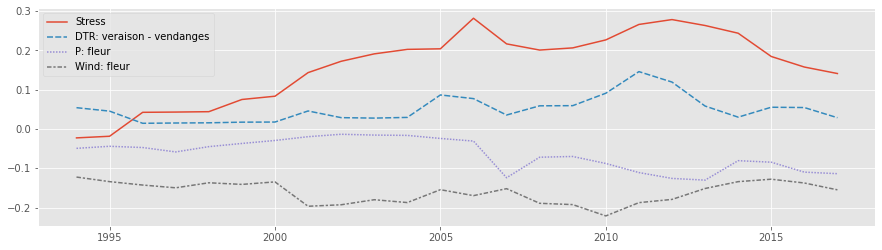

<AxesSubplot:>

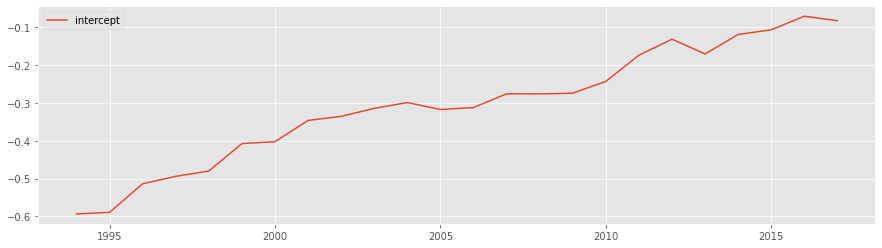

In [86]:
coefficients_df[coefficients_df.columns] = coefficients_df[coefficients_df.columns].apply(pd.to_numeric, errors='coerce', axis=1)

sns.lineplot(data = coefficients_df.iloc[:, 1:])
plt.show()

sns.lineplot(data=coefficients_df[['intercept']])

In [87]:
pnew = 1
pold = 0
polder = 0

predictions=[]
display(coefficients_df.head())

for vintage in tqdm(range(1994, 2018)):
    coefficients = coefficients_df.loc[(vintage-1):vintage, :].mean()
    if vintage == 1994:
        prediction = 6 + coefficients_df.loc[vintage, 'intercept']
        for feature in GOOD_FEATURES:
            prediction += coefficients_df.loc[vintage, feature] * X.loc[vintage, feature]
    
    elif vintage == 1995:
        prediction = 6 
        prediction += pnew * coefficients_df.loc[vintage, 'intercept'] + pold * next_coefficients_df.loc[vintage, 'intercept']
        for feature in GOOD_FEATURES:
            prediction += (pnew * coefficients_df.loc[vintage, feature] + pold * next_coefficients_df.loc[vintage, feature]) * X.loc[vintage, feature]
    else:
        prediction = 6 
        prediction += pnew * coefficients_df.loc[vintage, 'intercept'] + pold * next_coefficients_df.loc[vintage, 'intercept'] + polder * next_next_coefficients_df.loc[vintage, 'intercept']
        for feature in GOOD_FEATURES:
            prediction += (pnew * coefficients_df.loc[vintage, feature] + pold * next_coefficients_df.loc[vintage, feature]+ polder * next_next_coefficients_df.loc[vintage, feature]) * X.loc[vintage, feature]
    predictions.append(prediction)
print(predictions)

,intercept,Stress,DTR: veraison - vendanges,P: fleur,Wind: fleur
1994,-0.593470,-0.022357,0.054487,-0.048944,-0.122000
1995,-0.589327,-0.018199,0.045720,-0.043719,-0.133630
1996,-0.513580,0.042681,0.014769,-0.046885,-0.142319
1997,-0.494159,0.043333,0.015514,-0.058057,-0.149347
1998,-0.479965,0.044307,0.016012,-0.044608,-0.136548



[5.3426611977061755, 5.3710008778788065, 5.5635172701362725, 5.164729809976864, 5.536801067141484, 5.632606843189133, 5.895191583683399, 5.877936945448413, 5.569211705151849, 5.975813694561388, 5.903467457900681, 6.253985948282893, 5.422444213314405, 5.627498195244842, 5.786156347945643, 6.095985141352493, 6.17385149123365, 5.696694692231656, 6.381309358711453, 5.282314684499607, 5.662882872316367, 5.887616352949693, 6.264870320261138, 5.812545335156562]


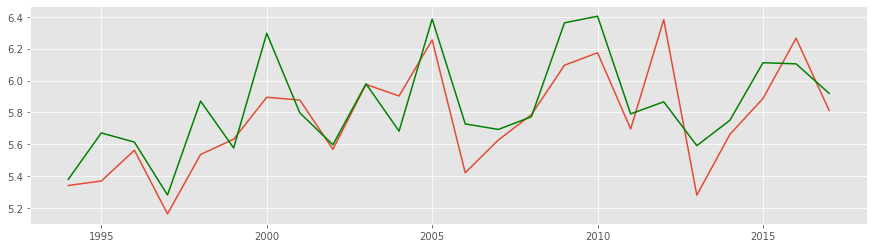

Spearman correlation between results and real log prices: first period
 0.690909090909091
Spearman correlation between results and real log prices: second period
 0.8131868131868131
Spearman correlation between results and real log prices: complete
 0.8026086956521737 

MAE  between results and real log prices: complete
 0.17251847518177696 

R2 between results and real log prices: complete
 0.4628703673117296


In [88]:
plt.plot(range(1994, 2018), predictions)
plt.plot(y.loc[1994:2017, 'Log price'], color='g')
plt.show()
print('Spearman correlation between results and real log prices: first period\n', spearmanr(predictions[:11], y.loc[1994:2004, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: second period\n', spearmanr(predictions[11:], y.loc[2005:2017, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: complete\n', spearmanr(predictions, y.loc[1994:2017, 'Log price'].values).correlation, '\n')

print('MAE  between results and real log prices: complete\n', np.mean(np.abs(predictions- y.loc[1994:, 'Log price'].values)), '\n')

print('R2 between results and real log prices: complete\n', r2_score(y.loc[1994:2017, 'Log price'].values, predictions))

### ['Stress', 'DTR: veraison - vendanges', 'P: fleur', 'Wind: fleur'], Sur Saint Emilion

Avec aucun smoothing :

>Spearman correlation between results and real log prices: complete
> 0.8226086956521739 
>
>MAE  between results and real log prices: complete
> 0.18230644252901182 
>
>R2 between results and real log prices: complete
> 0.47


Avec smoothing : pas mieux